The goal of this project is to answer five questions:
- Q1 - What part of my music taste can be described and predicted?
- Q2 - What are my favorite genres?
- Q3 - What are my favorite decades/periods?
- Q4 - What are some albums that I should've liked according to a well-trained model, but didn't?
- Q5 - What are some albums liked by me that a well trained-model expected me to dislike?

All five questions require statistical modelling. Even though on the first glance Q2 and Q3 could be answered only using descriptive statistics, we'll later see how selection bias in the sample obscures causality. In order to reliably estimate impact of genres and decades on my ratings, I need to use many factors at once.

### Libraries and settings

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.float_format', lambda x: '%.2f' % x)
np.set_printoptions(suppress=True)
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score, mean_squared_error

### Loading and preparing data

My ratings are what our models will try to predict. To help us out, we have other users' ratings, as well as some metadata, at our disposal.

In [2]:
my_ratings = pd.read_csv('my_ratings.csv').set_index('album').rename_axis('album').sort_index()
user_ratings = pd.read_csv('user_ratings.csv').set_index('album').sort_index()
metadata = pd.read_csv('metadata.csv').set_index('album').sort_index()

In [3]:
my_ratings.head()

,ID,SCORE
album,,
##### - #####,5249198,3.38
$$$tag$$$ - crowd surfing,7151963,2.91
'o'rang - herd of instinct,54502,2.77
(sandy) alex g - house of sugar,10341556,4.08
(sandy) alex g - rocket,8110777,4.05


In [4]:
user_ratings.head()

,5m6d7g,abetco,alliejk,amy111,aokiji,BennoVonArchimboldi,Bohun,b_flat_like_tires,carls_jr,CaterpillarMarch,...,tmonk11,TwiceStyle,vagabund____,vastell,vodsel,Windoze,working_title_7,yourenotcooking,ywy,_ashtraywasp
album,,,,,,,,,,,,,,,,,,,,,
##### - #####,NaN,3.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
$$$tag$$$ - crowd surfing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
'o'rang - herd of instinct,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
(sandy) alex g - house of sugar,NaN,3.50,NaN,4.00,NaN,3.50,NaN,NaN,NaN,NaN,...,NaN,3.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.50
(sandy) alex g - rocket,NaN,3.00,NaN,4.00,NaN,4.00,NaN,NaN,NaN,NaN,...,4.50,4.00,NaN,3.50,NaN,NaN,NaN,NaN,NaN,3.50


In [5]:
metadata.head()

,ID,year,genres
album,,,
##### - #####,5249198,2014,"Outsider House, Deep House"
$$$tag$$$ - crowd surfing,7151963,2016,Techno
'o'rang - herd of instinct,54502,1994,Post-Rock
(sandy) alex g - house of sugar,10341556,2019,"Neo-Psychedelia, Indie Folk"
(sandy) alex g - rocket,8110777,2017,"Indie Folk, Singer-Songwriter"


Object `my_ratings` stores the ratings I gave to various albums, EPs and singles. Each album has one rating attached to it and there is no temporal element in the data - we assume all ratings are up to date. My ratings can take value of any real number between 0 and 5.
Other users' ratings are stored in the `user_ratings` object. These ratings' values are between 0.5 and 5.0, with 0.5 increments. `NaN` values mean that a particular user hasn't rated this album. We can expect that appropriate handling of `NaN` values will be very important as we develop the model. Let's see how sparse is the dataset.

In [6]:
NaN_share = user_ratings.isnull().sum().sum() / np.prod(user_ratings.shape)
print(f"{NaN_share:.1%} of the fields are NaNs.")

83.0% of the fields are NaNs.


Other users' ratings comprise mostly albums that I also have rated but there can be a few exceptions. Additionally, my ratings can contain albums that other users haven't rated, or otherwise albums we don't have data on.
Let's ensure that we have the same albums in both datasets, by dropping some rows.

In [7]:
print(f'Before cleaning - my ratings: {my_ratings.shape[0]}, user ratings: {user_ratings.shape[0]}')

Before cleaning - my ratings: 3776, user ratings: 3652


In [8]:
albums_intersection = list(set(user_ratings.index).intersection(set(my_ratings.index)))
my_ratings = my_ratings.loc[albums_intersection]
user_ratings = user_ratings.loc[albums_intersection]

In [9]:
print(f'After cleaning - my ratings: {my_ratings.shape[0]}, user ratings: {user_ratings.shape[0]}')

After cleaning - my ratings: 3566, user ratings: 3566


# Exploratory data analysis and feature engineering

Quick check of available data.

In [10]:
my_vs_avg_rating = my_ratings.join(user_ratings.mean(axis=1).rename('avg_rating'))

In [11]:
ratings_corr = np.corrcoef(my_vs_avg_rating.SCORE, my_vs_avg_rating.avg_rating)[0][1]
print(f'Correlation between my ratings and average user ratings: {ratings_corr:.1%}')

Correlation between my ratings and average user ratings: 18.9%


Genres strings can contain multiple genres for the same album. Let's split them so they can be analyzed.

In [12]:
genres_split = [(index, row.genres.split(', ')) for index, row in metadata.iterrows()]
genres_df = pd.DataFrame(genres_split)
genres_df.set_index(0, inplace = True)
genres_df = genres_df[1].explode().rename('genre')

What are the most popular genres in my database?

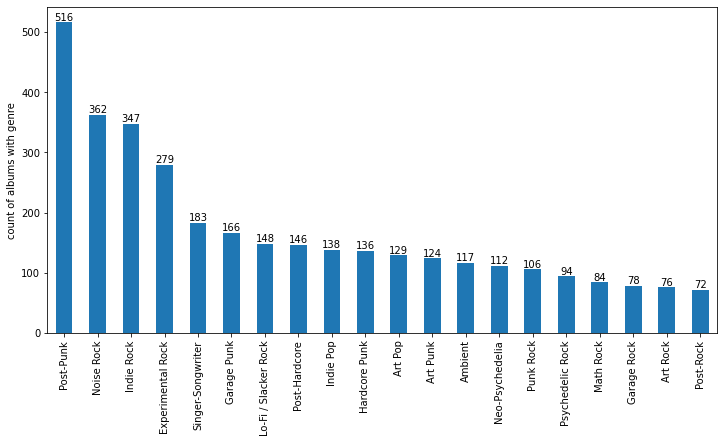

In [13]:
ax = genres_df.value_counts().head(20).plot(kind='bar', figsize = [12, 6])
plt.ylabel('count of albums with genre')
ax.bar_label(ax.containers[0]);

How many genres are assigned per album?

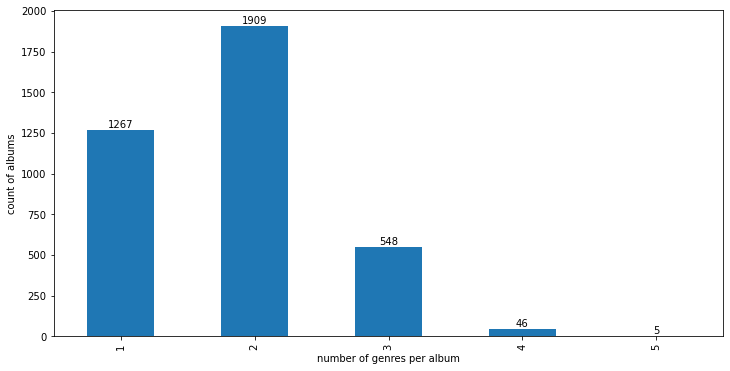

In [14]:
ax = genres_df.reset_index()[0].value_counts().value_counts().sort_index().plot(kind='bar', figsize = [12, 6])
plt.xlabel('number of genres per album');
plt.ylabel('count of albums')
ax.bar_label(ax.containers[0]);

What decade were the albums in my database released in?

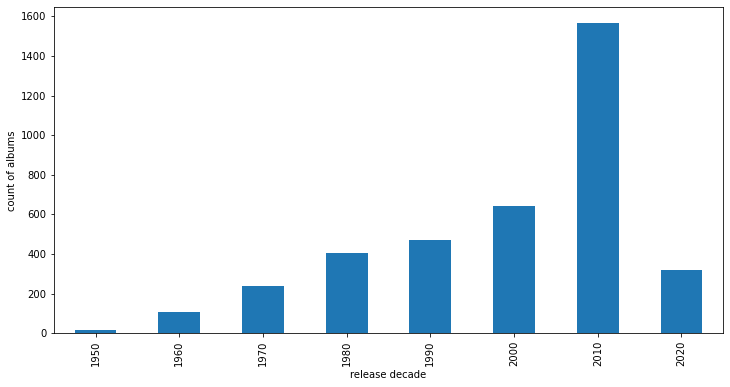

In [15]:
(10*np.floor(metadata.year/10)).astype(int).value_counts().sort_index().plot(kind='bar', figsize = [12, 6])
plt.xlabel('release decade');
plt.ylabel('count of albums');

For the purpose of model training let's create binary variables which check the genres strings against a list of words.

In [16]:
words_to_check = ['Rock', 'Punk', 'Pop', 'Post', 'Noise', 'Experimental', 'Rap', 'Hop', 'Jazz', 'Metal', 'Ambient', 'Indie', 'Art', 'Hardcore', 'Folk', 'Garage', 'Psychedel', 'Songwriter', 'Alternative', 'Industrial', 'Wave', 'Progressive', 'Avant', 'Techno', 'Synth', 'Math', 'Electronic', 'Jangle', 'Drone', 'Hypnagogic', 'Chamber', 'Contemporary', 'Power']

In [17]:
def check_for_a_word(word):
    def check_for_word(genre_list):
        return word in genre_list
    return check_for_word

In [19]:
for word in words_to_check:
    metadata['Is_'+word] = metadata.genres.apply(check_for_a_word(word)) * 1

In [20]:
metadata = pd.concat([metadata, pd.get_dummies(10*np.floor(metadata.year/10), prefix = 'Is')], axis = 1)

## Model training and evaluation functions

In [21]:
def loocv_regression(
    data, my_ratings, model=Ridge(alpha=100), fill = 2
):
    """
    Perform leave one regression on the provided dataset.

    Parameters
    __________
    data : pd.DataFrame
        Independent variables with which model will be trained.
    my_ratings : pd.DataFrame
        Dependent variable which model attempts to predict.
    model : object
        Model which can be fit on provided data.
    fill : float
        Value to replace NaNs with, for user ratings.

    Returns
    _______
    result : pd.DataFrame
        Predictions for each observation.
    """
    data_f = data.fillna(fill)
    i = 1
    albums = []
    predictions = []
    for index, _ in my_ratings.iterrows():
        i += 1
        X = data_f.loc[my_ratings.index].drop(index)
        y = my_ratings.drop(index)["SCORE"]
        model.fit(X, y)
        row_df = data_f.loc[[index]]
        pred = model.predict(row_df)
        albums.append(index)
        predictions.append(pred[0])
        print(f"Predicted rating for {index}: {pred[0]:.2f}")
    result = pd.DataFrame({"album": albums, "prediction": predictions}).sort_values(
        "prediction", ascending=False
    ).set_index('album')
    return result


In [22]:
def evaluate(predictions, my_ratings):
    """
    Evaluates predictions of my ratings generated by a model.
    Parameters
    __________
    predictions : pd.DataFrame
        Predictions generated by a model.
    my_ratings : pd.DataFrame
        Dependent variable which the model tried to predict.

    Returns
    _______
    r2 : float
        Coefficient of determination.
    rmse : float
        Root mean squared error.
    """
    df = pd.concat([predictions, my_ratings], axis = 1)
    r2 = r2_score(df.SCORE, df.prediction)
    rmse = mean_squared_error(df.SCORE, df.prediction, squared = False)
    return r2, rmse

## Model A

In [23]:
result_A = loocv_regression(user_ratings, my_ratings)
print(evaluate(result_A, my_ratings))
score_pred_A = pd.concat([result_A, my_ratings], axis = 1)

Predicted rating for the gun club - miami: 3.52
Predicted rating for morphine - cure for pain: 3.39
Predicted rating for jpegmafia - veteran: 4.07
Predicted rating for kaz bałagane x bel mondo - sos, ciuchy i borciuchy: 3.45
Predicted rating for juçara marçal - delta estácio blues: 3.53
Predicted rating for faust - faust iv: 3.79
Predicted rating for todd rundgren - something / anything?: 3.39
Predicted rating for sandwell district - feed-forward: 3.36
Predicted rating for woolen men - temporary monument: 3.43
Predicted rating for the feelies - crazy rhythms: 3.80
Predicted rating for these new puritans - hidden: 3.32
Predicted rating for jeff mills - live at the liquid room, tokyo: 3.46
Predicted rating for the world is a beautiful place & i am no longer afraid to die - whenever, if ever: 3.36
Predicted rating for the paper chase - hide the kitchen knives: 3.38
Predicted rating for paddy mcaloon - i trawl the megahertz: 3.26
Predicted rating for christian fennesz & jim o'rourke - it's

<AxesSubplot:xlabel='SCORE', ylabel='prediction'>

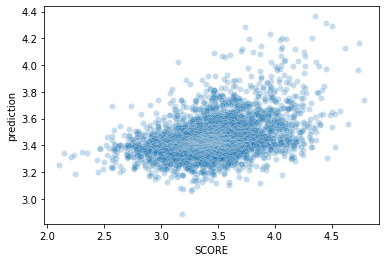

In [24]:
sns.scatterplot(x = 'SCORE', y = 'prediction', data = score_pred_A, alpha=0.25)

## Model B

In [25]:
result_B = loocv_regression(metadata.drop(columns=['genres', 'year']), my_ratings)
print(evaluate(result_B, my_ratings))

Predicted rating for the gun club - miami: 3.49
Predicted rating for morphine - cure for pain: 3.34
Predicted rating for jpegmafia - veteran: 3.50
Predicted rating for kaz bałagane x bel mondo - sos, ciuchy i borciuchy: 3.44
Predicted rating for juçara marçal - delta estácio blues: 3.60
Predicted rating for faust - faust iv: 3.39
Predicted rating for todd rundgren - something / anything?: 3.39
Predicted rating for sandwell district - feed-forward: 3.37
Predicted rating for woolen men - temporary monument: 3.50
Predicted rating for the feelies - crazy rhythms: 3.49
Predicted rating for these new puritans - hidden: 3.45
Predicted rating for jeff mills - live at the liquid room, tokyo: 3.35
Predicted rating for the world is a beautiful place & i am no longer afraid to die - whenever, if ever: 3.41
Predicted rating for the paper chase - hide the kitchen knives: 3.36
Predicted rating for paddy mcaloon - i trawl the megahertz: 3.34
Predicted rating for christian fennesz & jim o'rourke - it's

<AxesSubplot:>

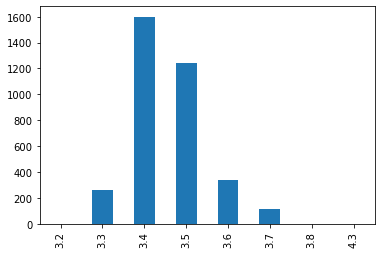

In [26]:
result_B.prediction.round(1).value_counts().sort_index().plot(kind='bar')

## Model C

In [27]:
full_data = pd.concat([user_ratings, metadata.drop(columns = ['ID', 'genres', 'year']).loc[user_ratings.index]], axis = 1)

In [28]:
result_C = loocv_regression(full_data, my_ratings)
print(evaluate(result_C, my_ratings))
score_pred_C = pd.concat([result_C, my_ratings], axis = 1)

Predicted rating for the gun club - miami: 3.59
Predicted rating for morphine - cure for pain: 3.35
Predicted rating for jpegmafia - veteran: 3.99
Predicted rating for kaz bałagane x bel mondo - sos, ciuchy i borciuchy: 3.46
Predicted rating for juçara marçal - delta estácio blues: 3.60
Predicted rating for faust - faust iv: 3.79
Predicted rating for todd rundgren - something / anything?: 3.35
Predicted rating for sandwell district - feed-forward: 3.38
Predicted rating for woolen men - temporary monument: 3.47
Predicted rating for the feelies - crazy rhythms: 3.82
Predicted rating for these new puritans - hidden: 3.36
Predicted rating for jeff mills - live at the liquid room, tokyo: 3.33
Predicted rating for the world is a beautiful place & i am no longer afraid to die - whenever, if ever: 3.37
Predicted rating for the paper chase - hide the kitchen knives: 3.32
Predicted rating for paddy mcaloon - i trawl the megahertz: 3.18
Predicted rating for christian fennesz & jim o'rourke - it's

<AxesSubplot:xlabel='SCORE', ylabel='prediction'>

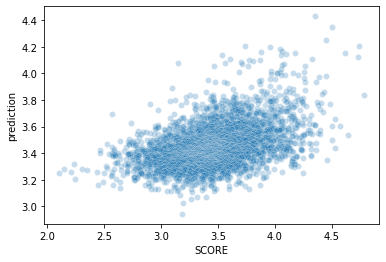

In [29]:
sns.scatterplot(x = 'SCORE', y = 'prediction', data = score_pred_C, alpha=0.25)

## Inference

In order to look at coefficients, we'll run the model on all available data.

In [30]:
model = Ridge(alpha = 100)
model.fit(full_data.fillna(2), my_ratings.SCORE)
coefs = pd.DataFrame({'feature': full_data.columns, 'coef': model.coef_})

How were the coefficients distributed for user ratings?

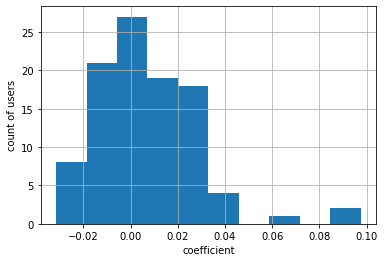

In [31]:
coefs.loc[~coefs.feature.str.startswith('Is')].coef.hist()
plt.xlabel('coefficient');
plt.ylabel('count of users');

How do coefficients look like for genre variables?

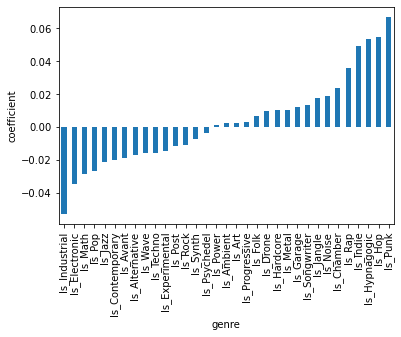

In [32]:
coefs.loc[coefs.feature.str.startswith('Is_')].loc[(~coefs.feature.str.contains('19')) & (~coefs.feature.str.contains('20'))].sort_values('coef').set_index(['feature']).coef.plot(kind='bar')
plt.xlabel('genre');
plt.ylabel('coefficient');

How do coefficients look like for decade variables?

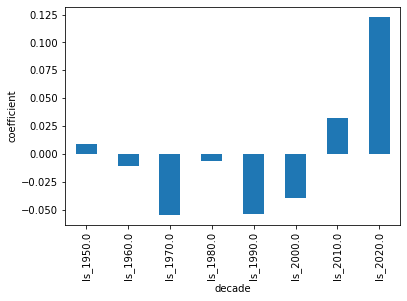

In [33]:
coefs.loc[coefs.feature.str.startswith('Is_')].loc[(coefs.feature.str.contains('19')) | (coefs.feature.str.contains('20'))].sort_values('feature').set_index(['feature']).coef.plot(kind='bar')
plt.xlabel('decade');
plt.ylabel('coefficient');

Let's finally use last LOO CV predictions to see which albums were most over- and underrated by the model.

In [34]:
score_pred_C['diff'] = score_pred_C.SCORE - score_pred_C.prediction

In [35]:
score_pred_C.sort_values('diff').head()

,prediction,ID,SCORE,diff
album,,,,
pink floyd - wish you were here,3.25,974,2.11,-1.14
swans - the glowing man,3.28,7299302,2.15,-1.14
the stone roses - the stone roses,3.70,314,2.57,-1.13
ty segall - manipulator,3.32,5568151,2.24,-1.08
world's end girlfriend - hurtbreak wonderland,3.26,781150,2.21,-1.05


In [36]:
score_pred_C.sort_values('diff', ascending = False).head()

,prediction,ID,SCORE,diff
album,,,,
frank ocean - blonde,3.53,7630705,4.64,1.11
holden - the inheritors,3.35,4485643,4.46,1.11
flight - lead riders,3.44,3112324,4.53,1.09
"sheer mag - ii 7""",3.50,6407241,4.50,1.00
anthony shake shakir - frictionalism 1994-2009,3.25,2654744,4.25,1.00
